In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re
import copy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms


from utils.model_analysis_nets import LeNet, VGG16, ResNet20
from utils.load import getGradients, getTotalLength, initDataset, minimizeProduct
from utils.load import getSamples, getTopofeature, extractWeights
from utils.load import inflectionpoint, gen_corr_matrix
from utils.pcode import isProperSuperset, findDifferentElements, flatten, findLargestGaps, grouping, simpleGrouping
# from utils.pcode import mergeSublistsWithSharedItems
from CKA import linear_CKA, kernel_CKA
import perscode

import numpy as np
import sympy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

from sklearn.manifold import MDS

import gudhi as gd
from ripser import Rips
from datetime import datetime


from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import MDS

In [2]:
trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
dataset_test = datasets.CIFAR10('../data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
colors = ['r', 'g', 'b', 'y', 'p']


Files already downloaded and verified
cuda


In [3]:

# attack_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_attack_save/"
# normal_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_normal_save/"
attack_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern04-27--19-19-23/local_attack_save/"
normal_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern04-27--19-19-23/local_normal_save/"
global_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern04-27--19-19-23/fed/"

round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
gmodelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
round_set.sort(reverse=True)
round_set = [x for x in round_set if x >= 30]
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

for dirpath, dirnames, filenames in os.walk(global_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        gmodelpth_set.append(os.path.join(dirpath, filename).replace("\\","/")) if "model" in filename else None

print("rounds", round_set, len(round_set))
print("attack", client_set_attack, len(client_set_attack))
print("normal", client_set_normal, len(client_set_normal))
print(len(modelpth_set))
print(len(gmodelpth_set))


modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)
client_max = min(30,len(client_set_attack),len(client_set_normal))


modelname = ""
weight_keys_resnet = ["conv1.weight", "layer1.0.conv1.weight", "layer1.0.conv2.weight", "layer1.1.conv1.weight", "layer1.1.conv2.weight", "layer1.2.conv1.weight", "layer1.2.conv2.weight", "layer2.0.conv1.weight", "layer2.0.conv2.weight",
 "layer2.1.conv1.weight", "layer2.1.conv2.weight", "layer2.2.conv1.weight", "layer2.2.conv2.weight", "layer3.0.conv1.weight", "layer3.0.conv2.weight", "layer3.1.conv1.weight", "layer3.1.conv2.weight", "layer3.2.conv1.weight", "layer3.2.conv2.weight"]

if "lenet" in attack_pth:
    modelname = "lenet"
    weightsize = 50
elif "VGG" in attack_pth:
    modelname = "vgg"
    weightsize = 64
elif "resnet" in attack_pth:
    modelname = "resnet"
    weightsize = 16
    weight_keys = weight_keys_resnet
else:
    assert 0==1


rounds [36, 34, 32, 30] 4
attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 40
normal [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] 60
640
16


In [7]:
now = datetime.now()
file_path = "/mnt/sda3/docker_space/Code/PHTDA-Net/data/corrset_temp_v3_5_2024-04-27-20-16-06_[36, 34, 32, 30]_[30_30].txt"


corr_set_recovered = []
normal_nums = int(re.findall(r'\d+', file_path)[-2])
attack_nums = int(re.findall(r'\d+', file_path)[-1])
total_nums = normal_nums+attack_nums

total_rounds = len(round_set)
loaded_data = np.loadtxt(file_path)
corr_matrices = loaded_data.reshape(total_rounds, total_nums, total_nums, 1)

for idx, matrix in enumerate(corr_matrices):
    round_number = idx  # or fetch from a saved round number list if available
    corr_set_recovered.append([round_number, matrix])

corr_set = corr_set_recovered


In [8]:
def k_distance(data, k):
    """
    Compute the k-distance graph for a given distance matrix.

    Parameters:
    data (numpy.ndarray): An n x n distance matrix.
    k (int): The number of neighbors to consider.

    Returns:
    numpy.ndarray: Sorted k-distances for all points.
    """
    # Ensure the diagonal is infinity, as we don't consider a point's distance to itself
    np.fill_diagonal(data, np.inf)

    # Sort each row and take the k-th nearest distance
    sorted_distances = np.sort(data, axis=1)
    k_distances = sorted_distances[:, k-1]

    # Sort the k-distances of all points
    sorted_k_distances = np.sort(k_distances)

    return sorted_k_distances

# Example usage:
# Let's assume `distance_matrix` is your nxn distance matrix and you choose k = 4
# distance_matrix = np.random.rand(100, 100)  # Replace with your actual distance matrix
# k = 4
# sorted_k_distances = k_distance(distance_matrix, k)

# Plotting the k-distance graph
# plt.figure(figsize=(10, 6))
# plt.plot(sorted_k_distances)
# plt.xlabel('Points')
# plt.ylabel(f'{k}-Distance')
# plt.title(f'{k}-Distance Graph')
# plt.grid(True)
# plt.show()

# Note: Uncomment and modify the above code according to your `distance_matrix` and desired `k` value.


36 (60, 60)


/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


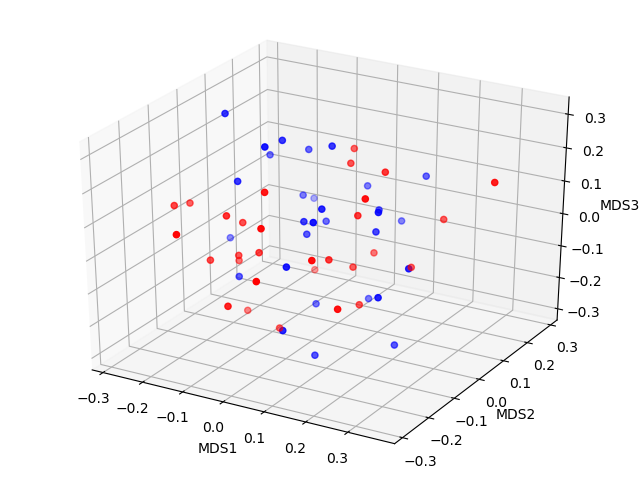

34 (60, 60)


/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

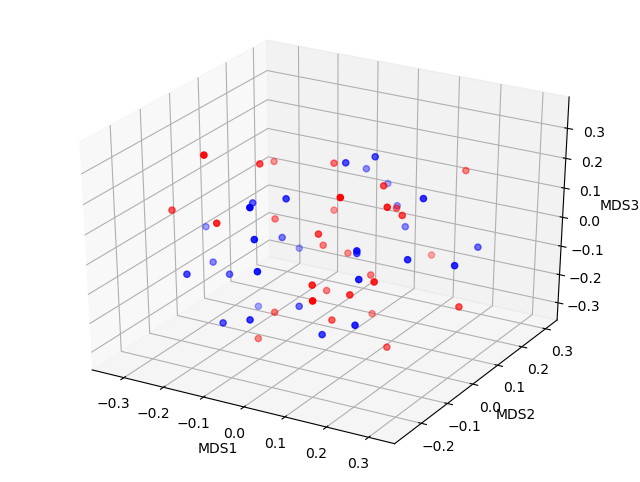

32 (60, 60)


/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

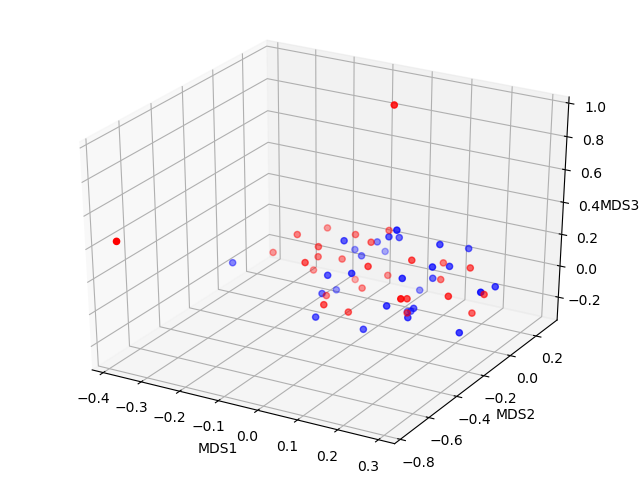

30 (60, 60)


/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

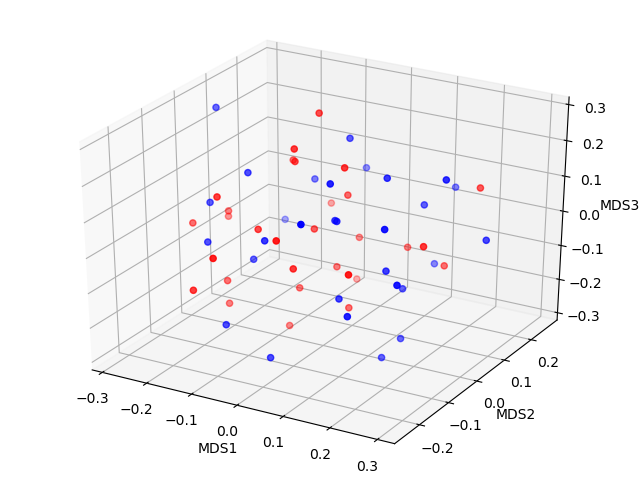

<Figure size 640x480 with 0 Axes>

In [15]:
from sklearn.cluster import KMeans
%matplotlib inline
for round_number, corr in corr_set:
    data = 1 - corr.reshape(-1, total_nums) - corr.reshape(-1, total_nums).T
    print(round_set[round_number], data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    # sns.heatmap(1-data)
    # plt.show()

    mds = MDS(n_components=3, dissimilarity='precomputed', random_state=1)
    mds_coords = mds.fit_transform(data)

    # 绘制3D图
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = ['blue'] * normal_nums + ['red'] * attack_nums
    ax.scatter(mds_coords[:, 0], mds_coords[:, 1], mds_coords[:, 2], c=colors)

    ax.set_xlabel('MDS1')
    ax.set_ylabel('MDS2')
    ax.set_zlabel('MDS3')
    # plt.title('3D Multi-Dimensional Scaling (MDS) Visualization')
    plt.show()
    plt.savefig('3d_mds_visualization.svg', format='svg') if round_number == 36

    





36 (60, 60)


/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


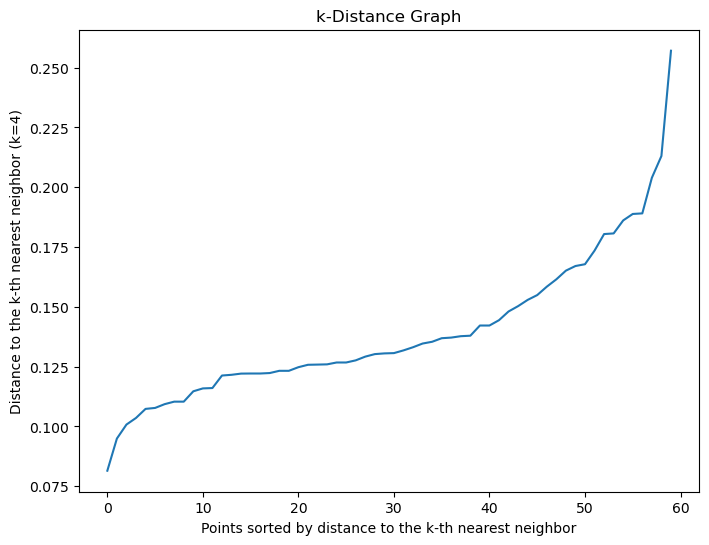

[[inf, []], [0.28993887786844796, [[9, 23]]], [0.2818362721627844, [[9, 54]]], [0.2698035590532365, [[40, 42]]], [0.2669161969649867, [[16, 18]]], [0.2531422857961556, [[17, 27]]], [0.2518162875651542, [[19, 22]]], [0.25136101006828304, [[47, 51]]], [0.2505689457918625, [[12, 34]]], [0.2418547680203379, [[18, 30]]], [0.2368553236674752, [[12, 32]]], [0.2319775223943239, [[40, 49]]], [0.23177315324790448, [[26, 38]]], [0.23172782943896053, [[26, 55]]], [0.23132194519059923, [[22, 31]]], [0.23129249919319128, [[29, 37]]], [0.22996297444583125, [[33, 45]]], [0.22867394225930493, [[7, 32]]], [0.22648970869493668, [[9, 20]]], [0.22346682854953437, [[35, 37]]], [0.21946761289797334, [[10, 39]]], [0.2191167682283639, [[21, 34]]], [0.21697411437894254, [[50, 56]]], [0.21538657634683123, [[20, 50]]], [0.2151912925330728, [[25, 53]]], [0.21042039737365992, [[3, 25]]], [0.20979298271263902, [[39, 58]]], [0.20653255224570344, [[36, 43]]], [0.20614943400853714, [[0, 53]]], [0.20541130673464147, [[1

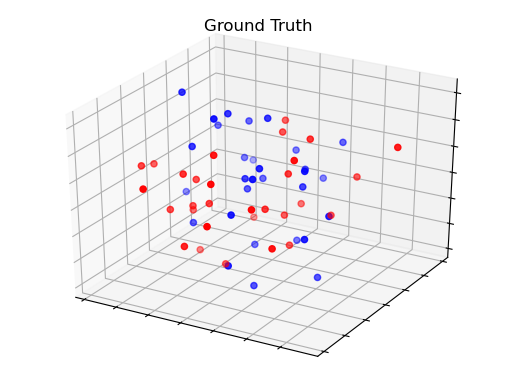

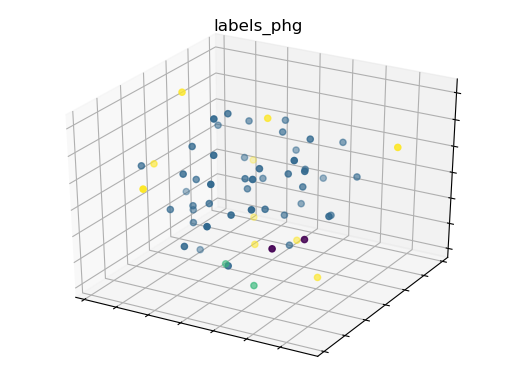

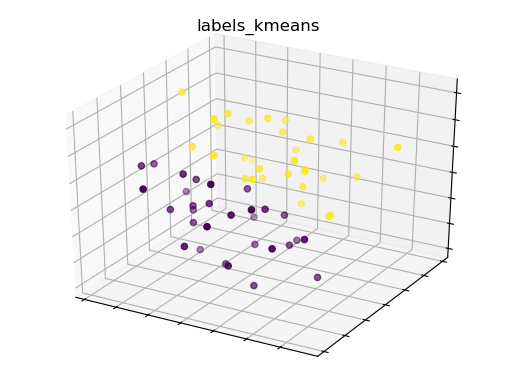

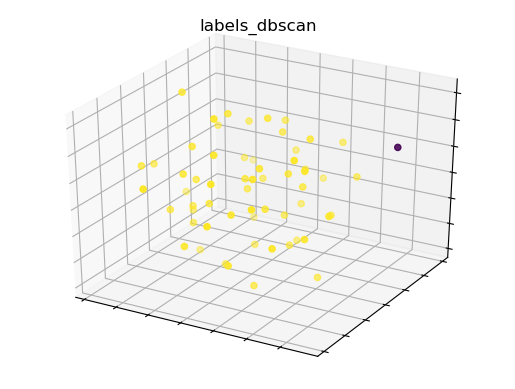

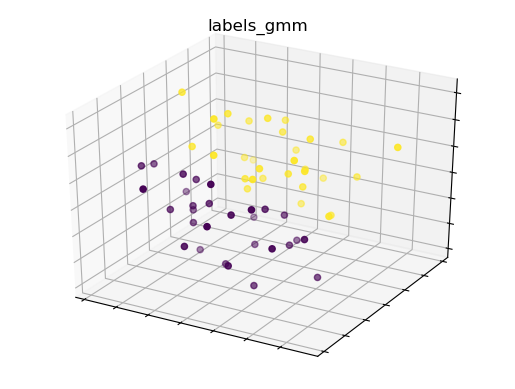

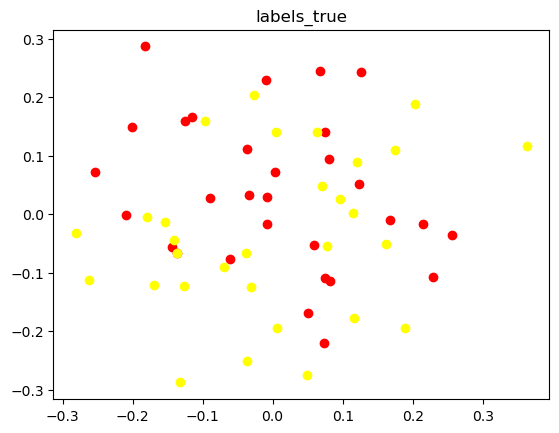

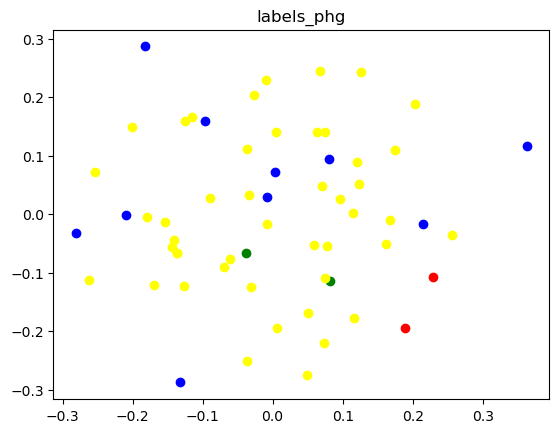

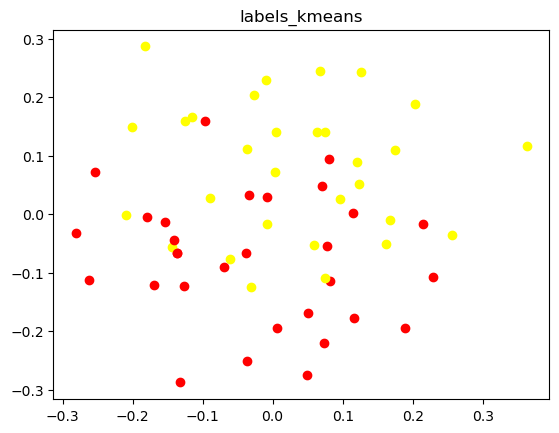

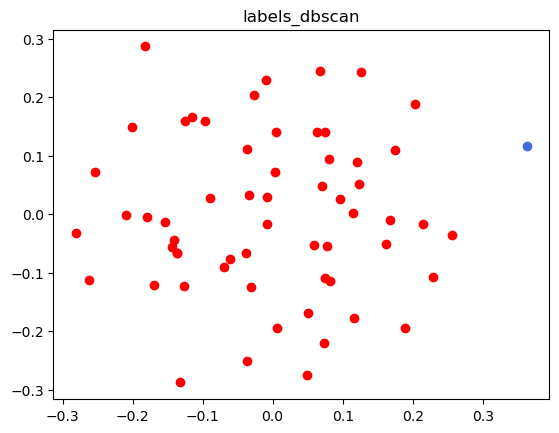

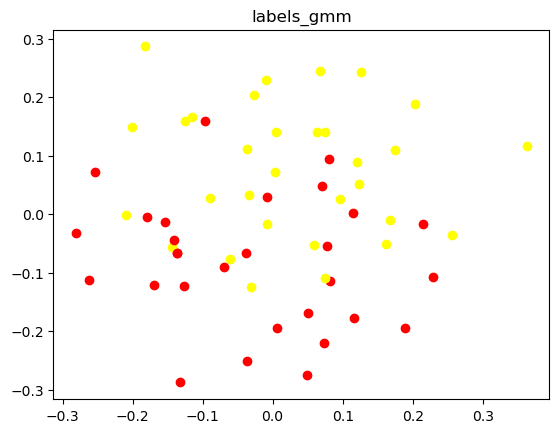

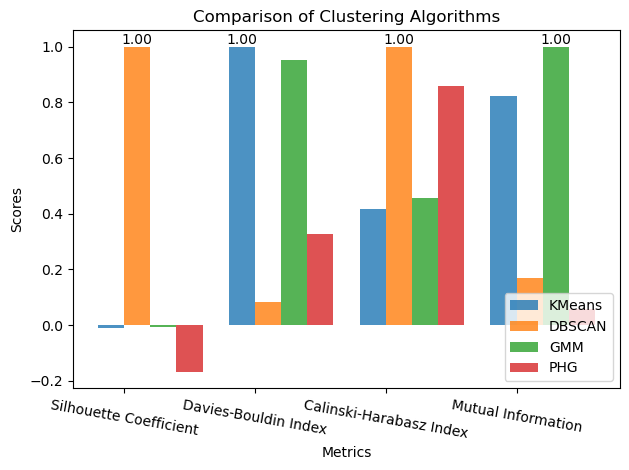

{'Silhouette Coefficient': {'KMeans': -0.010590504086376894, 'DBSCAN': 1.0, 'GMM': -0.004942487235769781, 'PHG': -0.16704972815632388}, 'Davies-Bouldin Index': {'KMeans': 1.0, 'DBSCAN': 0.08353640504647025, 'GMM': 0.95357152528875, 'PHG': 0.3263507738405566}, 'Calinski-Harabasz Index': {'KMeans': 0.41714083425113707, 'DBSCAN': 1.0, 'GMM': 0.45751239946975636, 'PHG': 0.8594863619467062}, 'Mutual Information': {'KMeans': 0.8219322581376124, 'DBSCAN': 0.16971429013624464, 'GMM': 1.0, 'PHG': 0.05922568417888652}}
34 (60, 60)


/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


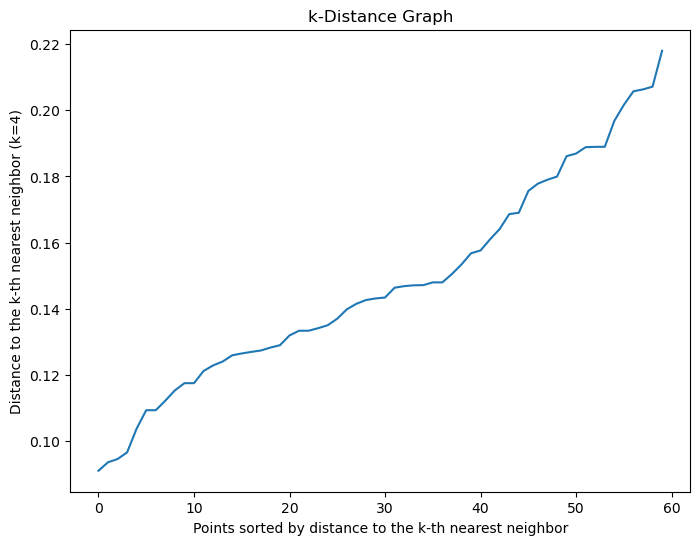

[[inf, []], [0.29390154055942497, [[34, 55]]], [0.2755553659946999, [[7, 41]]], [0.2717201388444521, [[43, 57]]], [0.26762361893070996, [[24, 33]]], [0.260177222264229, [[2, 17]]], [0.25297344489952645, [[5, 22]]], [0.24971981293263767, [[25, 50]]], [0.24958995374292525, [[13, 25]]], [0.23856584516566048, [[2, 51]]], [0.2385178889930768, [[23, 59]]], [0.23556383243681633, [[9, 54]]], [0.23343121752057594, [[45, 49]]], [0.2332576384023557, [[22, 32]]], [0.2320201956764164, [[18, 59]]], [0.23201369753904455, [[8, 13]]], [0.22971780562905442, [[39, 47]]], [0.2272297271903685, [[30, 56]]], [0.22656432085821776, [[16, 18]]], [0.22641413796144305, [[3, 21]]], [0.2202491351855913, [[10, 45]]], [0.21963932601561598, [[6, 39]]], [0.2195142007155304, [[37, 45]]], [0.21866664479111075, [[6, 38]]], [0.21778275793815505, [[4, 30]]], [0.21440657498823668, [[47, 52]]], [0.21407250719775206, [[0, 26]]], [0.2126764455214537, [[41, 48]]], [0.2117898840042972, [[3, 36]]], [0.2109921922867397, [[11, 37]]]

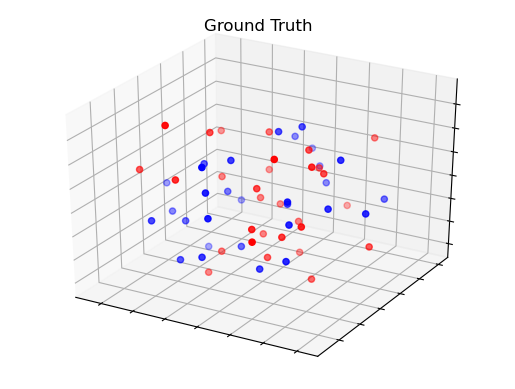

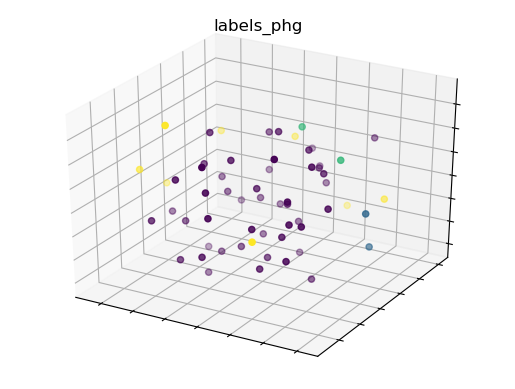

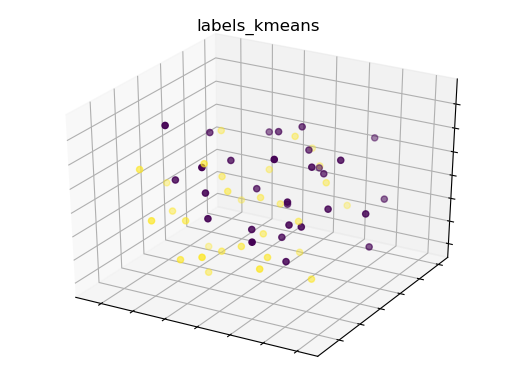

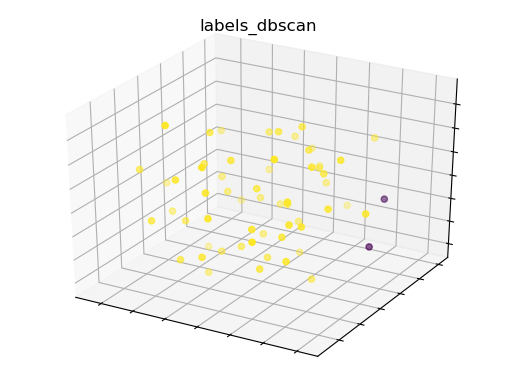

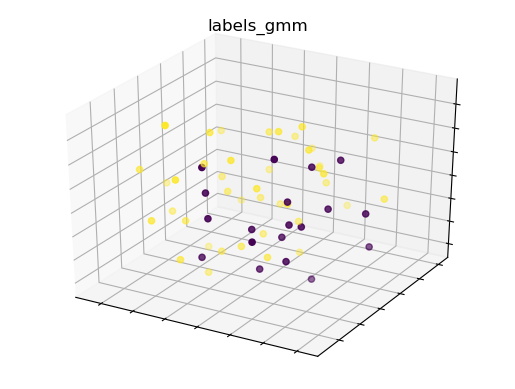

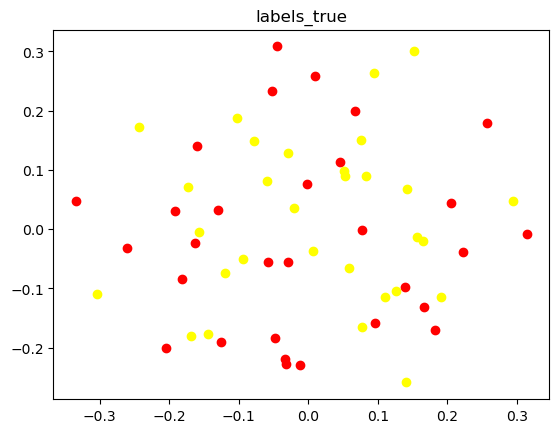

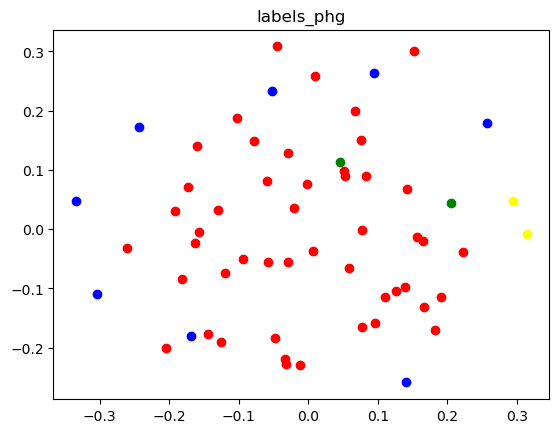

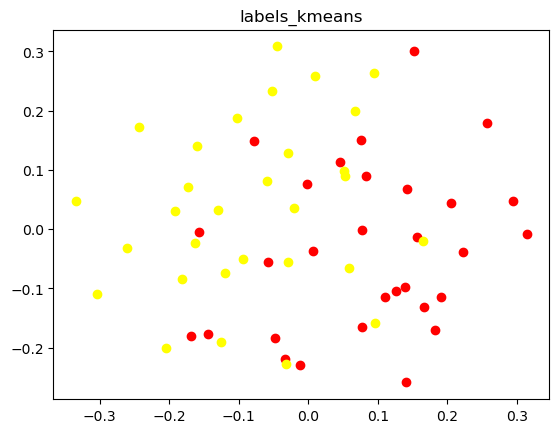

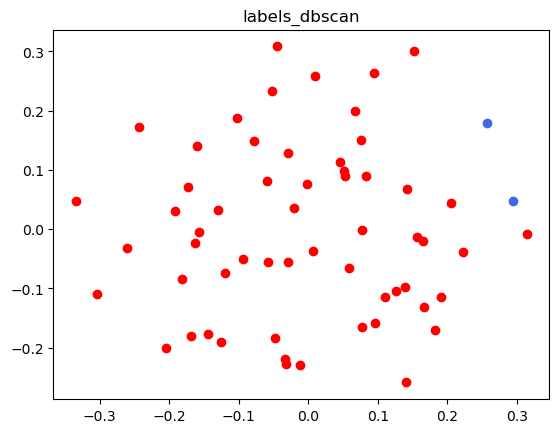

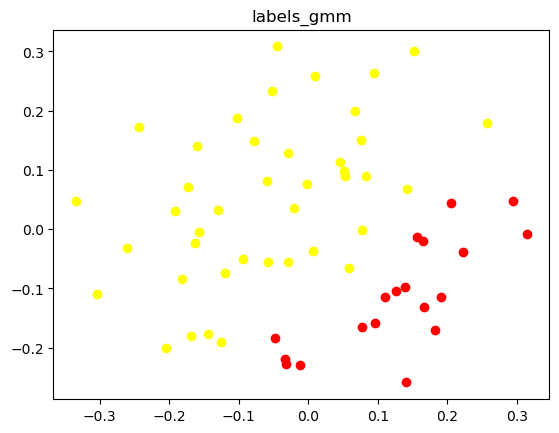

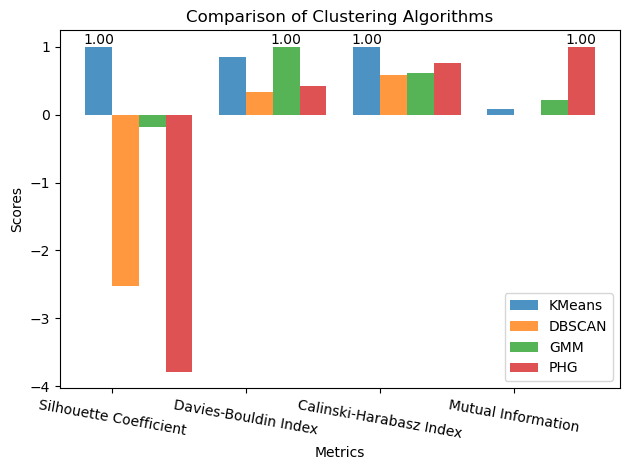

{'Silhouette Coefficient': {'KMeans': 1.0, 'DBSCAN': -2.515785698838621, 'GMM': -0.18086764793081522, 'PHG': -3.783813779715996}, 'Davies-Bouldin Index': {'KMeans': 0.8476376562164539, 'DBSCAN': 0.3248315675503334, 'GMM': 1.0, 'PHG': 0.42730173284756906}, 'Calinski-Harabasz Index': {'KMeans': 1.0, 'DBSCAN': 0.580122458561495, 'GMM': 0.6140977085888097, 'PHG': 0.7576158820310395}, 'Mutual Information': {'KMeans': 0.08141247767283026, 'DBSCAN': 0.0, 'GMM': 0.21214011026868015, 'PHG': 1.0}}
32 (60, 60)


/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


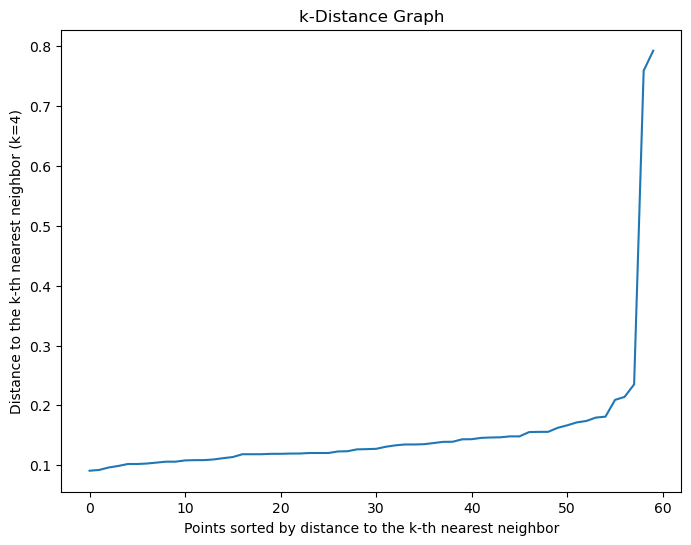

[[inf, []], [1.0, [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]]], [1.0, [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]]], [0.27699728707780813, [[0, 35]]], [0.26963005054663913, [[15, 26]]], [0.26804780774044823, [[20, 21]]], [0.26570310364653604, [[6, 57]]], [0.2517268621060973, [[14, 47]]], [0.24352530250692472, [[5, 31]]], [0.2412980860817293, [[28, 31]]], [0.23187231809685738, [[29, 34]]], [0.22883576532342043, [[22, 37]]], [0.22715495158943055, [[50, 56]]], [0.224215477616851, [[0, 44]]], [0.22351648144121927, [[48, 54]]], [0.21727176412516502, [[13, 55]]], [0.21655906126632818, [[20, 27]]], [0.21532590325047551, [[

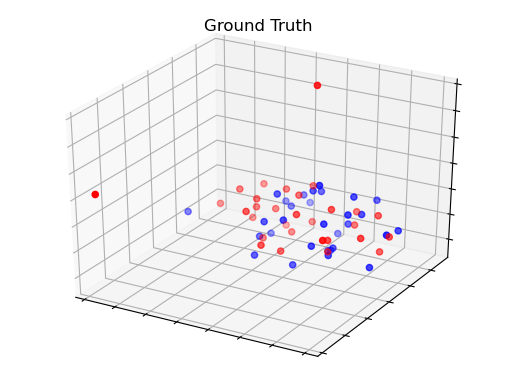

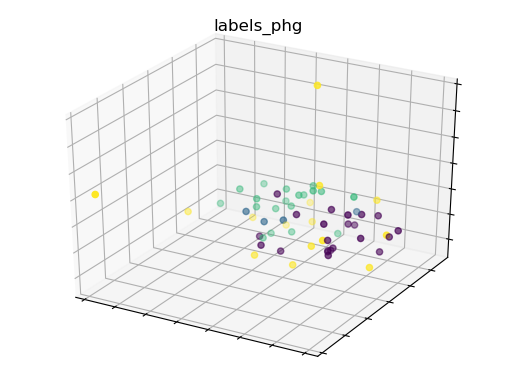

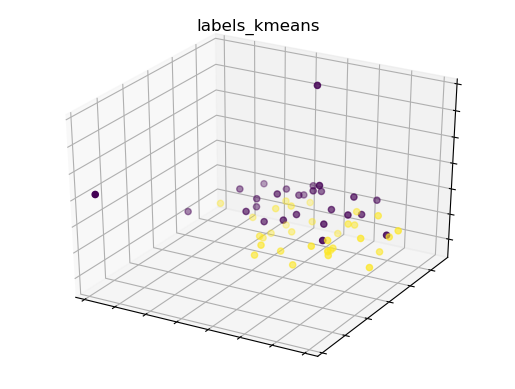

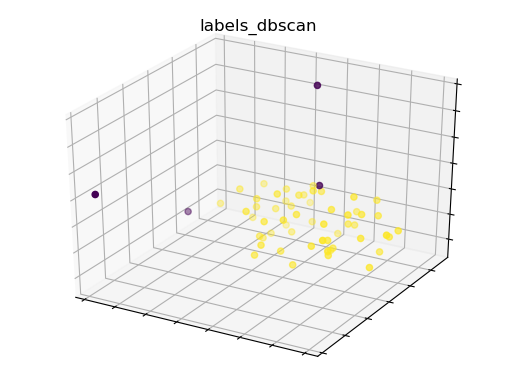

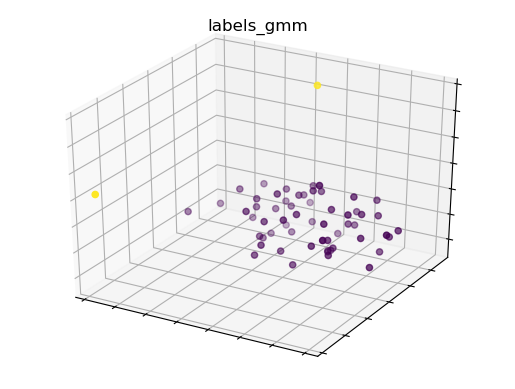

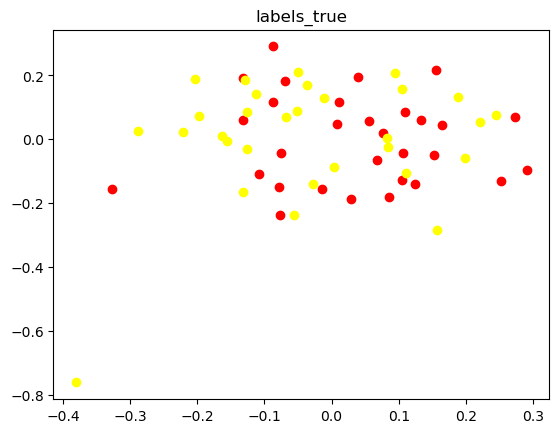

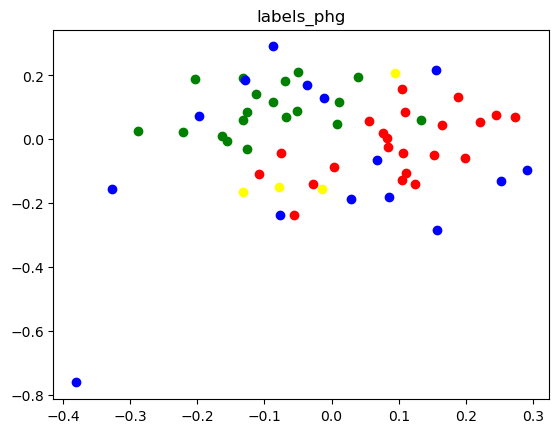

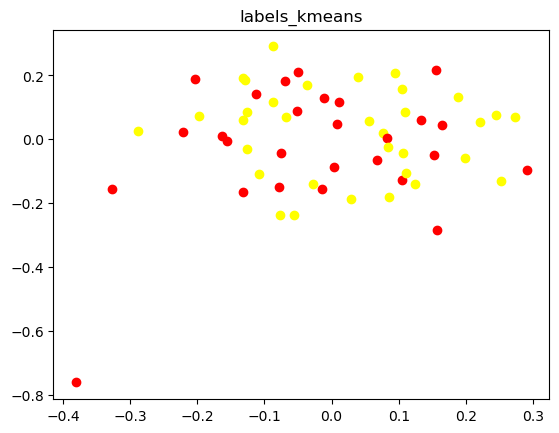

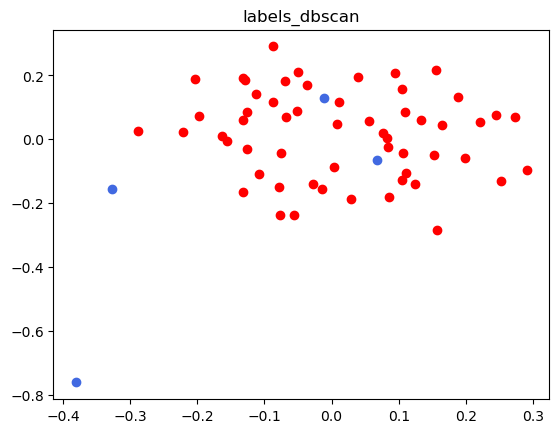

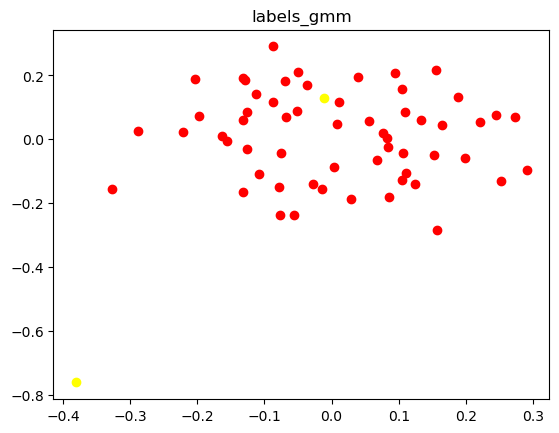

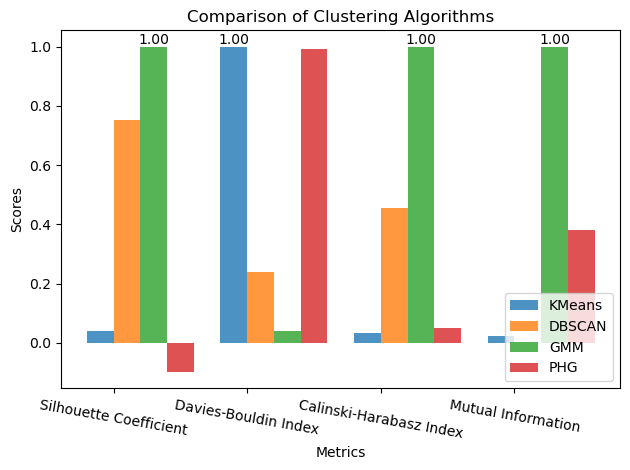

{'Silhouette Coefficient': {'KMeans': 0.03818990186449973, 'DBSCAN': 0.751845950545675, 'GMM': 1.0, 'PHG': -0.09774659456001879}, 'Davies-Bouldin Index': {'KMeans': 1.0, 'DBSCAN': 0.2395142784824401, 'GMM': 0.03851353711978076, 'PHG': 0.9917894986501001}, 'Calinski-Harabasz Index': {'KMeans': 0.03131429642758716, 'DBSCAN': 0.4549323280308528, 'GMM': 1.0, 'PHG': 0.04854895467213191}, 'Mutual Information': {'KMeans': 0.02370282218738156, 'DBSCAN': 0.0, 'GMM': 1.0, 'PHG': 0.3799795608765187}}
30 (60, 60)


/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


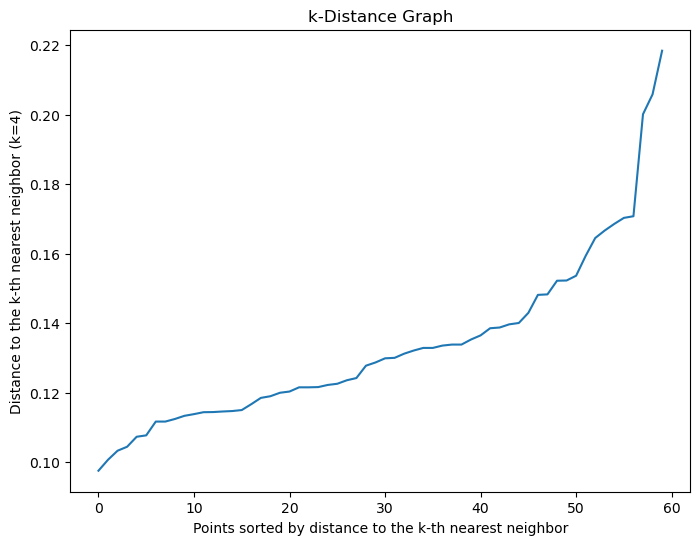

[[inf, []], [0.2722067889869799, [[10, 36]]], [0.2525646072703853, [[40, 45]]], [0.24710498733237451, [[12, 39]]], [0.2458231473242276, [[39, 58]]], [0.2411863629328581, [[23, 39]]], [0.23918629553774018, [[0, 13]]], [0.23173791184450165, [[6, 18]]], [0.23025174219966993, [[36, 52]]], [0.23016286683513865, [[34, 57]]], [0.22359318955680174, [[24, 34]]], [0.22350846707260386, [[4, 41]]], [0.2222009512926144, [[30, 47]]], [0.2176041321631924, [[29, 49]]], [0.21458038757495035, [[19, 50]]], [0.21429244309847073, [[46, 58]]], [0.21245424189496365, [[7, 29]]], [0.21226698498975383, [[5, 54]]], [0.20890708769530308, [[33, 46]]], [0.20771336283548392, [[22, 51]]], [0.20704116140974926, [[17, 28]]], [0.20638303501289945, [[37, 48]]], [0.20204758396549016, [[20, 25]]], [0.20178312897759532, [[1, 28]]], [0.1998478470608378, [[48, 54]]], [0.19898796085554615, [[18, 55]]], [0.19868313127882486, [[28, 35]]], [0.19796020485131316, [[27, 47]]], [0.19729321343319228, [[0, 50]]], [0.1955289875492684, [

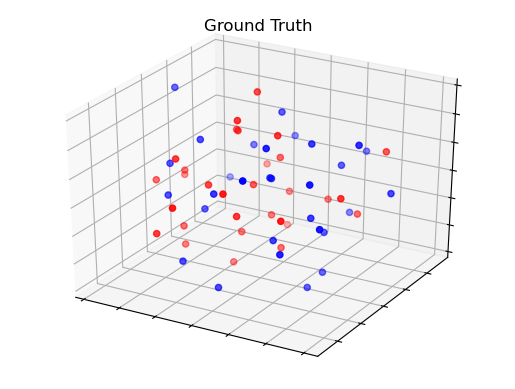

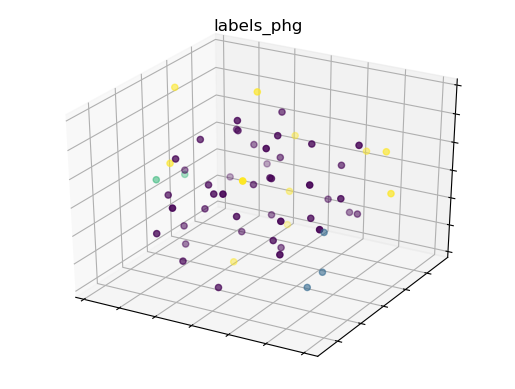

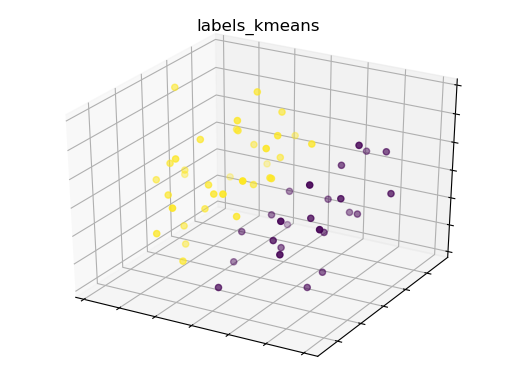

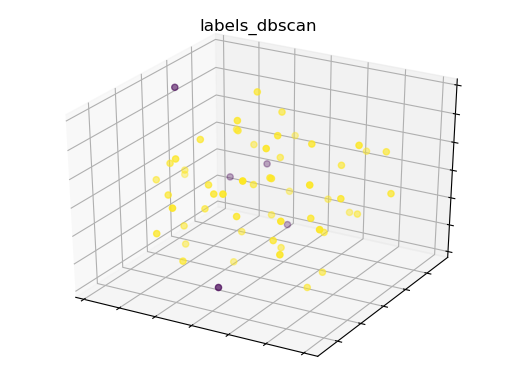

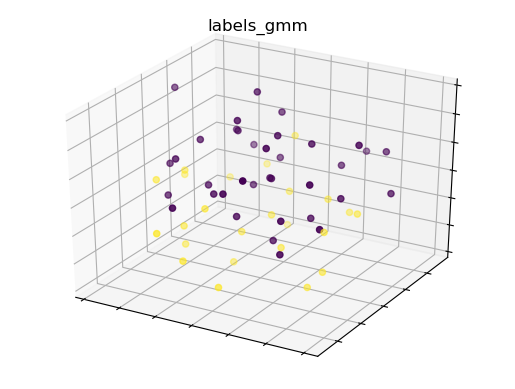

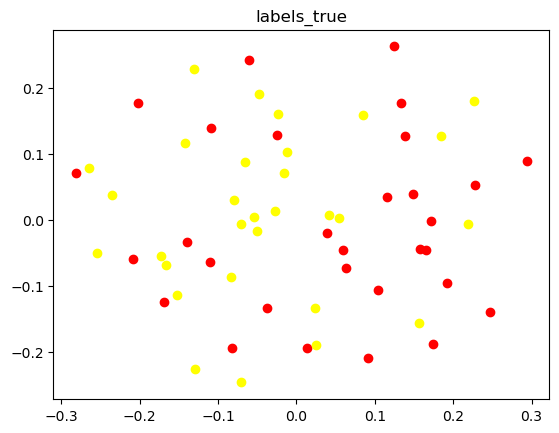

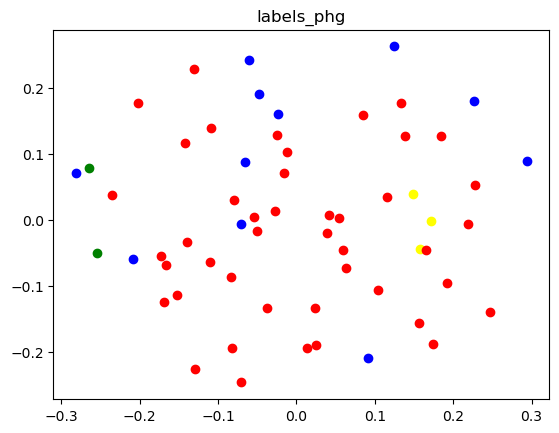

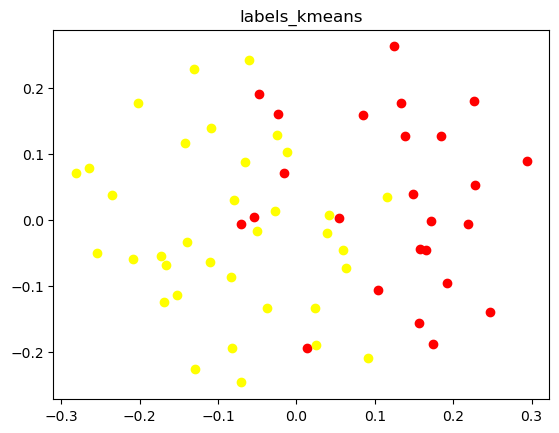

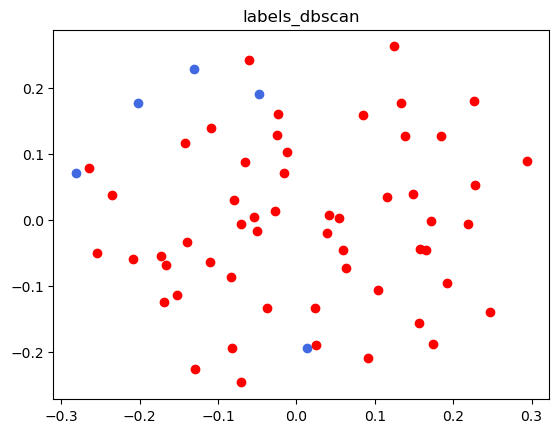

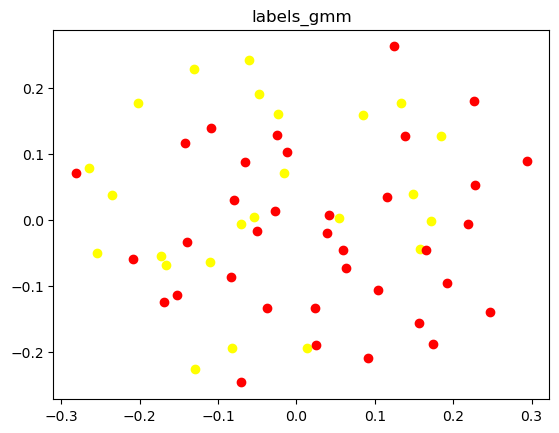

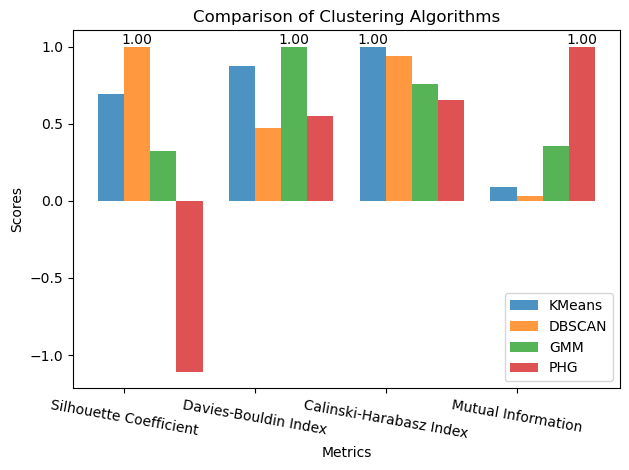

{'Silhouette Coefficient': {'KMeans': 0.6922419792633531, 'DBSCAN': 1.0, 'GMM': 0.3212503436829252, 'PHG': -1.1079851223820683}, 'Davies-Bouldin Index': {'KMeans': 0.8767323036049913, 'DBSCAN': 0.47425425572332747, 'GMM': 1.0, 'PHG': 0.5512586409566302}, 'Calinski-Harabasz Index': {'KMeans': 1.0, 'DBSCAN': 0.9376721757006824, 'GMM': 0.7571865452716553, 'PHG': 0.6545934708961187}, 'Mutual Information': {'KMeans': 0.08692377610978383, 'DBSCAN': 0.030862387394467693, 'GMM': 0.35435859729699426, 'PHG': 1.0}}


In [45]:
from sklearn.cluster import KMeans
%matplotlib inline
for round_number, corr in corr_set:
    data = 1 - corr.reshape(-1, total_nums) - corr.reshape(-1, total_nums).T
    print(round_set[round_number], data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    # sns.heatmap(1-data)
    # plt.show()

    mds = MDS(n_components=3, dissimilarity='precomputed', random_state=1)
    mds_coords = mds.fit_transform(data)

    mds_moredims = MDS(n_components=16, dissimilarity='precomputed', random_state=1)
    mds_coords_moredims = mds.fit_transform(data)

    
    sorted_distances = inflectionpoint(mds_coords_moredims)
    fig = plt.figure(figsize=(8, 6))
    plt.plot(sorted_distances)
    plt.xlabel('Points sorted by distance to the k-th nearest neighbor')
    plt.ylabel(f'Distance to the k-th nearest neighbor (k={4})')
    plt.title('k-Distance Graph')
    plt.show()

    kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
    dbscan = DBSCAN(eps=sorted_distances[50], min_samples=5)
    gmm = GaussianMixture(n_components=2, random_state=0)

    labels_true = [0] * normal_nums + [1] * attack_nums
    labels_kmeans = kmeans.fit_predict(mds_coords_moredims)
    labels_dbscan = dbscan.fit_predict(mds_coords_moredims)
    labels_gmm = gmm.fit_predict(mds_coords_moredims)

    labels_phg = simpleGrouping(data, 3, dbg=True)
    print(labels_phg)

    # 绘制3D图
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = ['blue'] * normal_nums + ['red'] * attack_nums
    ax.scatter(mds_coords[:, 0], mds_coords[:, 1], mds_coords[:, 2], c=colors)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    plt.title('Ground Truth')
    plt.show()


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = labels_phg
    ax.scatter(mds_coords[:, 0], mds_coords[:, 1], mds_coords[:, 2], c=colors)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    plt.title('labels_phg')
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = labels_kmeans
    ax.scatter(mds_coords[:, 0], mds_coords[:, 1], mds_coords[:, 2], c=colors)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    plt.title('labels_kmeans')
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = labels_dbscan
    ax.scatter(mds_coords[:, 0], mds_coords[:, 1], mds_coords[:, 2], c=colors)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    plt.title('labels_dbscan')
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = labels_gmm
    ax.scatter(mds_coords[:, 0], mds_coords[:, 1], mds_coords[:, 2], c=colors)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    plt.title('labels_gmm')
    plt.show()

    %matplotlib inline
    color = ["red", "yellow", "green", "blue", "orange", "navy", "royalblue"]
    fig, ax = plt.subplots()
    for idx, p in enumerate(mds_coords_moredims):
        ax.scatter(p[0], p[1], c=color[labels_true[idx]])
    plt.title('labels_true')
    plt.show()
    fig, ax = plt.subplots()
    for idx, p in enumerate(mds_coords_moredims):
        ax.scatter(p[0], p[1], c=color[labels_phg[idx]])
    plt.title('labels_phg')
    plt.show()
    fig, ax = plt.subplots()
    for idx, p in enumerate(mds_coords_moredims):
        ax.scatter(p[0], p[1], c=color[labels_kmeans[idx]])
    plt.title('labels_kmeans')
    plt.show()
    fig, ax = plt.subplots()
    for idx, p in enumerate(mds_coords_moredims):
        ax.scatter(p[0], p[1], c=color[labels_dbscan[idx]])
    plt.title('labels_dbscan')
    plt.show()
    fig, ax = plt.subplots()
    for idx, p in enumerate(mds_coords_moredims):
        ax.scatter(p[0], p[1], c=color[labels_gmm[idx]])
    plt.title('labels_gmm')
    plt.show()

    X = data
    silhouette_kmeans = silhouette_score(X, labels_kmeans)
    silhouette_dbscan = silhouette_score(X, labels_dbscan)
    silhouette_gmm = silhouette_score(X, labels_gmm)
    silhouette_phg = silhouette_score(X, labels_phg)

    davies_bouldin_kmeans = davies_bouldin_score(X, labels_kmeans)
    davies_bouldin_dbscan = davies_bouldin_score(X, labels_dbscan)
    davies_bouldin_gmm = davies_bouldin_score(X, labels_gmm)
    davies_bouldin_phg = davies_bouldin_score(X, labels_phg)

    calinski_harabasz_kmeans = calinski_harabasz_score(X, labels_kmeans)
    calinski_harabasz_dbscan = calinski_harabasz_score(X, labels_dbscan)
    calinski_harabasz_gmm = calinski_harabasz_score(X, labels_gmm)
    calinski_harabasz_phg = calinski_harabasz_score(X, labels_phg)

    mutual_info_kmeans = mutual_info_score(labels_true, labels_kmeans)
    mutual_info_dbscan = mutual_info_score(labels_true, labels_dbscan)
    mutual_info_gmm = mutual_info_score(labels_true, labels_gmm)
    mutual_info_phg = mutual_info_score(labels_true, labels_phg)

    %matplotlib inline
    # 定义评价指标和算法的数据
    result = {
        "Silhouette Coefficient": {
            "KMeans": silhouette_kmeans,
            "DBSCAN": silhouette_dbscan,
            "GMM": silhouette_gmm,
            "PHG": silhouette_phg
        },
        "Davies-Bouldin Index": {
            "KMeans": davies_bouldin_kmeans,
            "DBSCAN": davies_bouldin_dbscan,
            "GMM": davies_bouldin_gmm,
            "PHG": davies_bouldin_phg
        },
        "Calinski-Harabasz Index": {
            "KMeans": calinski_harabasz_kmeans,
            "DBSCAN": calinski_harabasz_dbscan,
            "GMM": calinski_harabasz_gmm,
            "PHG": calinski_harabasz_phg
        },
        "Mutual Information": {
            "KMeans": mutual_info_kmeans,
            "DBSCAN": mutual_info_dbscan,
            "GMM": mutual_info_gmm,
            "PHG": mutual_info_phg
        }
    }

    normalized_data = {}
    for metric, scores in result.items():
        if metric == 'Davies-Bouldin Index(Reversed)':
            min_value = min(scores.values())
            normalized_data[metric] = {algo: (score - min_value) / (max(scores.values()) - min_value) for algo, score in scores.items()}
        else:
            max_value = max(scores.values())
            normalized_data[metric] = {algo: score / max_value for algo, score in scores.items()}


    # 转换数据格式以便绘图
    metrics = list(normalized_data.keys())
    algorithms = list(normalized_data[metrics[0]].keys())
    scores = {algo: [normalized_data[metric][algo] for metric in metrics] for algo in algorithms}

    # 计算每个指标的最佳得分
    max_scores = {
        metric: max(normalized_data[metric].values())
        for metric in metrics
    }

    # 绘制条形图
    fig, ax = plt.subplots()
    plt.xticks(rotation=-10)
    bar_width = 0.2
    opacity = 0.8
    index = np.arange(len(metrics))

    for i, algo in enumerate(algorithms):
        bars = ax.bar(index + i * bar_width, scores[algo], bar_width, alpha=opacity, label=algo)
        # 为最佳得分添加红色标注
        for bar, score, metric in zip(bars, scores[algo], metrics):
            if score == max_scores[metric]:
                # bar.set_color('red')
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(), '%.2f' % score, ha='center', va='bottom', color='black')

    # 添加标签、标题和图例
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Clustering Algorithms')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(metrics)
    ax.legend(loc="lower right")


    # 展示图表
    plt.tight_layout()
    plt.show()

    print(normalized_data)



    





In [43]:

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mutual_info_score
X = data
silhouette_kmeans = silhouette_score(X, labels_kmeans)
silhouette_dbscan = silhouette_score(X, labels_dbscan)
silhouette_gmm = silhouette_score(X, labels_gmm)
silhouette_phg = silhouette_score(X, labels_phg)

davies_bouldin_kmeans = davies_bouldin_score(X, labels_kmeans)
davies_bouldin_dbscan = davies_bouldin_score(X, labels_dbscan)
davies_bouldin_gmm = davies_bouldin_score(X, labels_gmm)
davies_bouldin_phg = davies_bouldin_score(X, labels_phg)

calinski_harabasz_kmeans = calinski_harabasz_score(X, labels_kmeans)
calinski_harabasz_dbscan = calinski_harabasz_score(X, labels_dbscan)
calinski_harabasz_gmm = calinski_harabasz_score(X, labels_gmm)
calinski_harabasz_phg = calinski_harabasz_score(X, labels_phg)

# 由于Mutual Information需要真实标签，我们使用测试集的一部分
# labels_true = [0]*90+[1]*90+[2]*20
labels_true = y
mutual_info_kmeans = mutual_info_score(labels_true, labels_kmeans)
mutual_info_dbscan = mutual_info_score(labels_true, labels_dbscan)
mutual_info_gmm = mutual_info_score(labels_true, labels_gmm)
mutual_info_phg = mutual_info_score(labels_true, labels_phg)

NameError: name 'y' is not defined